This notebook documents the process of creating a quantum kernel manually from a given quantum support vector classifier. A successful(?) Quantum Kernel needs to:
- Have a quantum circuit component that is a paramaterized feature map, where the parameters encode an input feature datapoint.

- Have the transpose of that feature map as a separable quantum circuit component, that separately encodes an input feature datapoint.

- A way to calculate the fidelity (inner product) of the output of those two circuits - in the Qiskit quantum kernel, this is done by placing the transpose after the original with hadamards in between, and then taking repeated circuit measurements from the circuit.

- We need the fidelity calculation to be based on measuring the expectation value of some observable, so that it can work with the quantum circuit cutting addon.

- At present, we consider an approach based on the SWAP test, and an approach based on the Hadamard test.

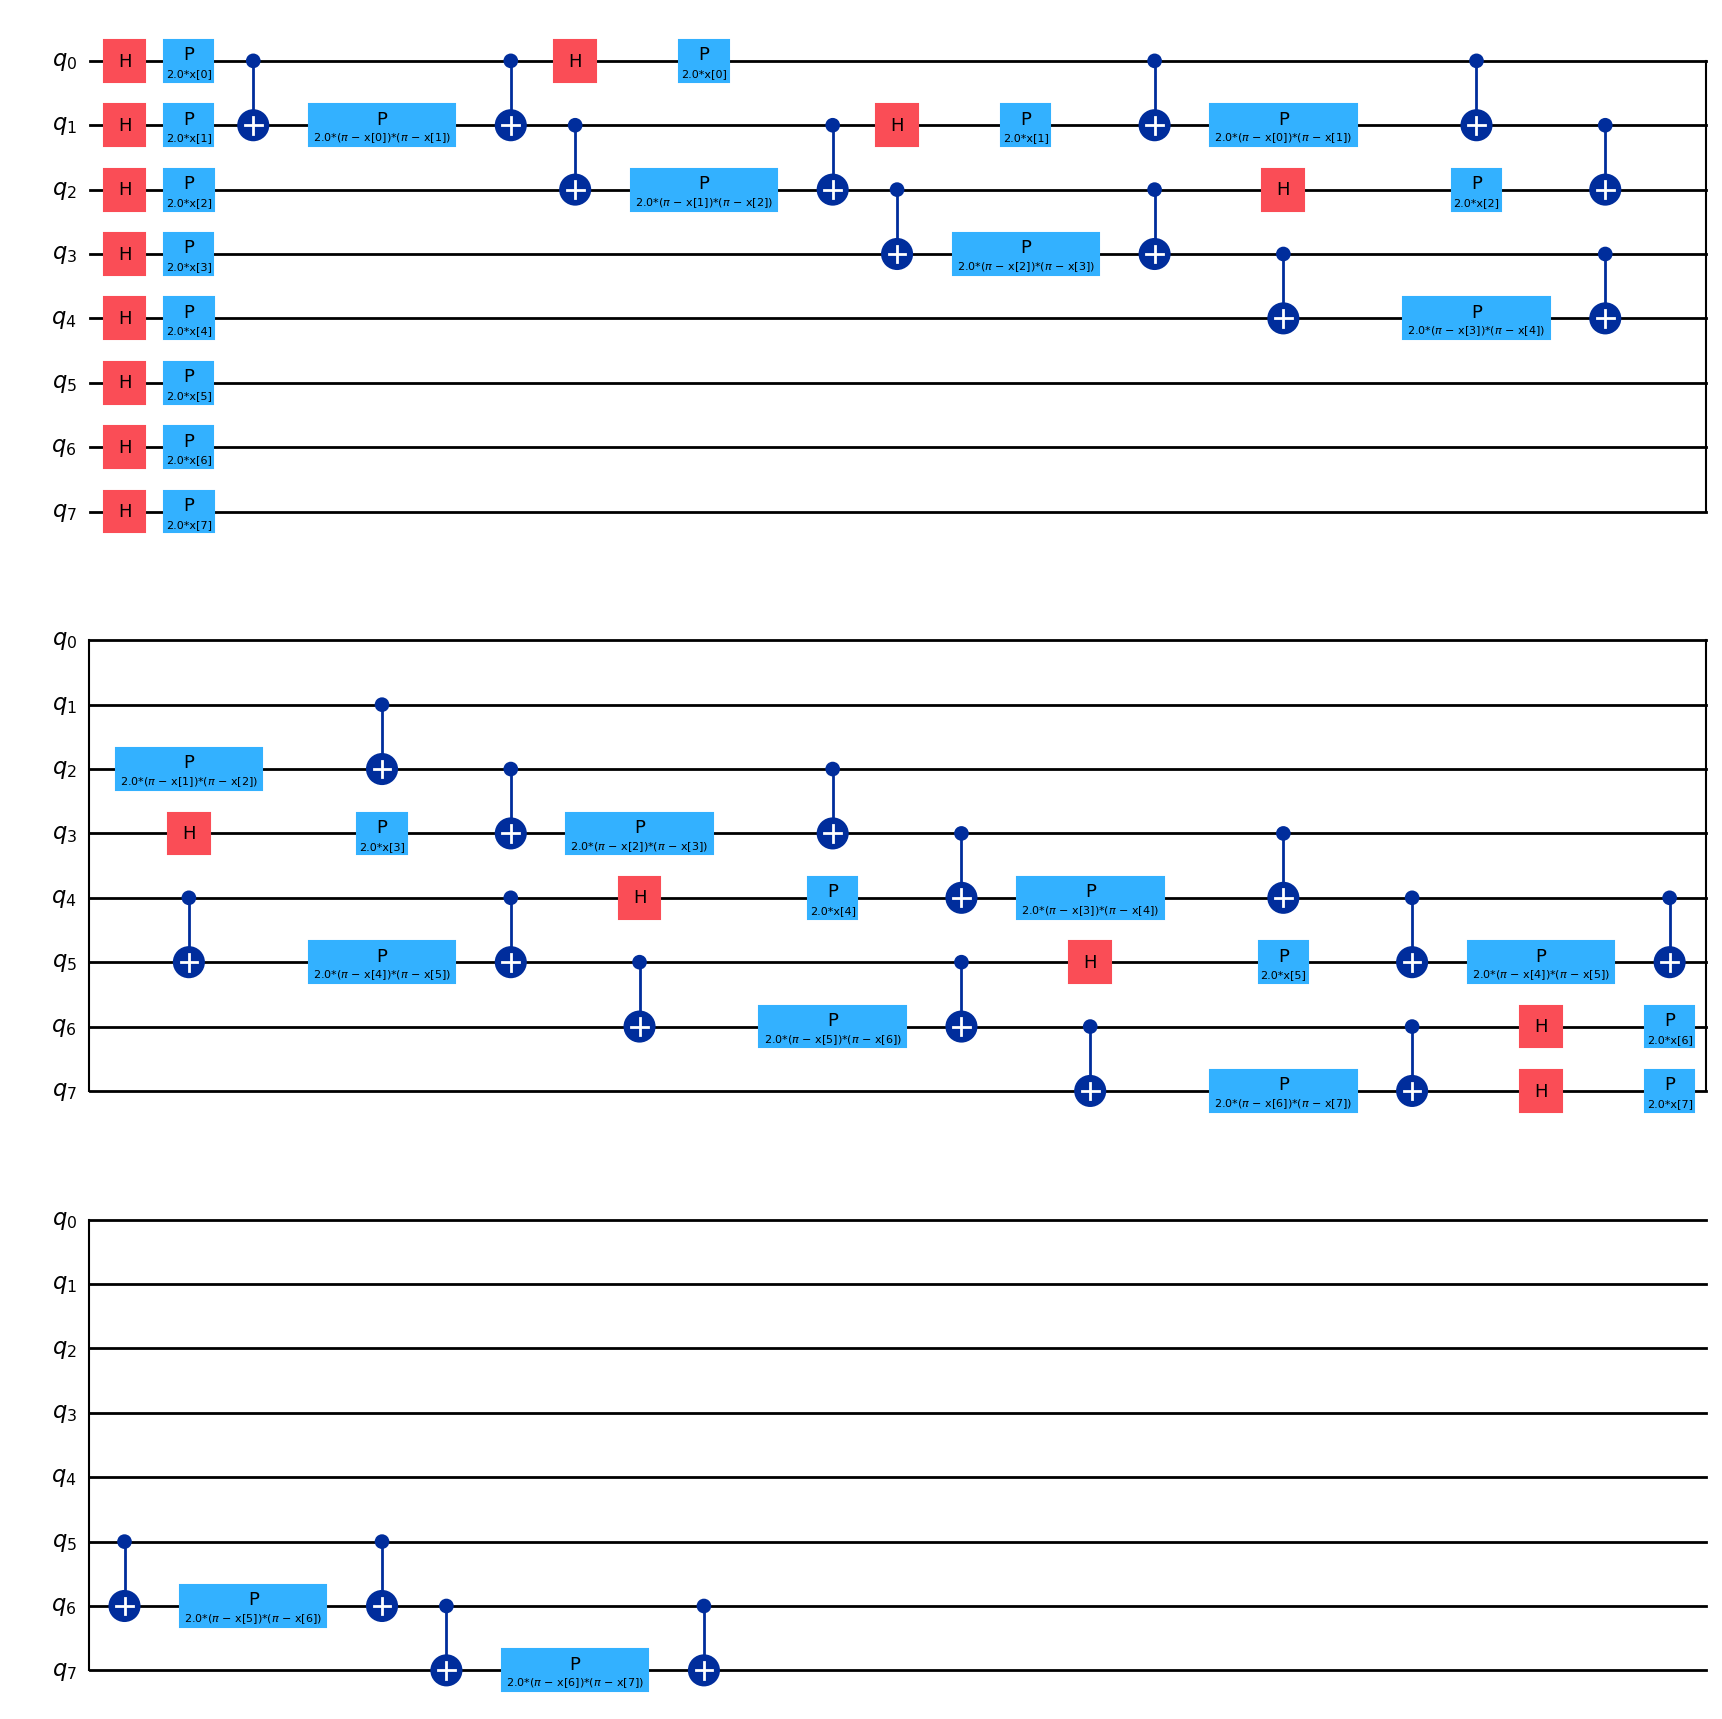

In [1]:
# Quantum Kernel using Qiskit ML

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector


NUM_QUBITS = 8

adhoc_feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=2, entanglement="linear").decompose()
# feature_map = QuantumCircuit(16)
#Using feature_map here causes the parameter dimensions mismatch issue previously seen.
#decomposing the ZZFeatureMap directly is not a problem however
# feature_map.compose(adhoc_feature_map.decompose())

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

adhoc_feature_map.draw("mpl")

#adhoc_feature_map.decompose().depth()



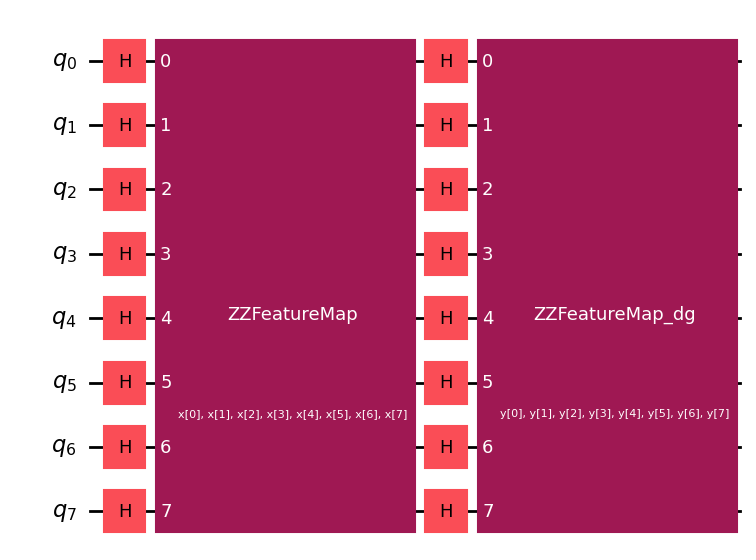

In [2]:
# Quantum Kernel manually.

from qiskit import QuantumCircuit
 
manual_kernel = QuantumCircuit(NUM_QUBITS)

U_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=2, entanglement="linear")

for i in range(NUM_QUBITS):
    manual_kernel.h(i)


manual_kernel = manual_kernel.compose(U_map)

for i in range(NUM_QUBITS):
    manual_kernel.h(i)

U_map_transpose = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=2, entanglement="linear", parameter_prefix='y').inverse()

#This forms a manual kernel with two parameter groups, x for U and y for U+
#Try measuring the required observable exp val on this kernel with values for the parameters.
# Figure out how the kernel assigns the parameters - see the QuantumKernel documentation.

manual_kernel = manual_kernel.compose(U_map_transpose)

manual_kernel.draw("mpl")


In [3]:
from qiskit.circuit.library import QFT, QuantumVolume
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from disqco.circuits.QAOA import QAOA_random
from qiskit import transpile
from QASMBench.interface.qiskit import QASMBenchmark
from disqco.graphs.quantum_network import QuantumNetwork


num_qubits = NUM_QUBITS


# circuit = QuantumVolume(num_qubits, 10)

circuit = manual_kernel

num_partitions = 3 # Define the number of partitions or QPUs you will distribute over
depth = circuit.depth()

qpu_size = num_qubits // num_partitions + 1 # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

# Create a quantum network with the specified number of qubits and partitions

# If we do not specificy the connectivity, we have all-to-all by default.

quantum_network = QuantumNetwork(qpu_sizes)


basis_gates = ['u', 'cp']

# Transpile the circuit to the basis gates
#circuit = transpile(circuit, basis_gates=basis_gates)

print(f'Number of qubits in circuit {circuit.num_qubits}')
print(f'Circuit depth: {circuit.depth()}')

print(f'Circuit parameters: {circuit.parameters}')

#circuit.measure_all()

circuit.draw("mpl")

ModuleNotFoundError: No module named 'disqco'

In [4]:
# calculating fidelity between two states using the kernel
from qiskit_aer import AerSimulator

## Dataset
# Example dataset: 2 samples, 16 features total (8 for x, 8 for y)
dataset = np.array([
    np.random.rand(16),
    np.random.rand(16)
])
print(dataset)

#Assign datapoints

[[0.62220692 0.9816968  0.3028464  0.32637856 0.38392441 0.70053915
  0.46672061 0.53466651 0.34489917 0.20038719 0.16497988 0.12881935
  0.2457952  0.48763982 0.78564019 0.1810859 ]
 [0.55366548 0.37477658 0.10083004 0.83609558 0.97467591 0.62947698
  0.84378837 0.20031067 0.53246779 0.47718845 0.58236367 0.68692505
  0.45400113 0.37506102 0.72100081 0.34153758]]


In [6]:
# Use the statevector simulator
simulator = AerSimulator()

#x = ParameterVector('x', 8)
#y = ParameterVector('y', 8)
circuit = manual_kernel



#Transpile the quantum circuit, then use circuit.assign_parameters({x: 8}) but with param vector.
# Find how to adjust the parameter vectors generated by the ZZfeaturemaps.

for i, datapoint in enumerate(dataset):
    x_vals = datapoint[:8]
    y_vals = datapoint[8:]

    # Bind parameters
    #param_dict = {x[j]: x_vals[j] for j in range(8)}
    #param_dict.update({y[j]: y_vals[j] for j in range(8)})

    bound_circuit = circuit.assign_parameters(datapoint)

    # Transpile and simulate
    tqc = transpile(bound_circuit, simulator)
    tqc.save_statevector()
    result = simulator.run(tqc).result()
    #print(result)

    # Get the statevector
    statevector = result.get_statevector()
    ##can only measure statevector on a simulator (which this is)
    print(f"Sample {i} statevector:\n", statevector)

bound_circuit.draw("mpl")

NameError: name 'transpile' is not defined

In [7]:
# Measure as observable in SparsePauliOp (used by circuit cutting)
from qiskit.quantum_info import SparsePauliOp
import itertools

#Define the observable |0><0| as a Pauli Observable for NUM_QUBITS number of gates.

pauli_labels = [''.join(p) for p in itertools.product('IZ', repeat=NUM_QUBITS)]

# Assign 1/(2^n) coefficient
coeff = 1/ (2**NUM_QUBITS)

coeffs = np.full(len(pauli_labels), coeff, dtype=np.float64)

#make the SparsePauliOp 

proj_0_op = SparsePauliOp.from_list(list(zip(pauli_labels, coeffs)))

print(proj_0_op)



#bound_circuit = circuit.assign_parameters(datapoint)



#tqc = transpile(bound_circuit, simulator)

#measuring an observable using the circuit cutting method. (no cuts - AAAAAAAA assignment)


SparsePauliOp(['IIIIIIII', 'IIIIIIIZ', 'IIIIIIZI', 'IIIIIIZZ', 'IIIIIZII', 'IIIIIZIZ', 'IIIIIZZI', 'IIIIIZZZ', 'IIIIZIII', 'IIIIZIIZ', 'IIIIZIZI', 'IIIIZIZZ', 'IIIIZZII', 'IIIIZZIZ', 'IIIIZZZI', 'IIIIZZZZ', 'IIIZIIII', 'IIIZIIIZ', 'IIIZIIZI', 'IIIZIIZZ', 'IIIZIZII', 'IIIZIZIZ', 'IIIZIZZI', 'IIIZIZZZ', 'IIIZZIII', 'IIIZZIIZ', 'IIIZZIZI', 'IIIZZIZZ', 'IIIZZZII', 'IIIZZZIZ', 'IIIZZZZI', 'IIIZZZZZ', 'IIZIIIII', 'IIZIIIIZ', 'IIZIIIZI', 'IIZIIIZZ', 'IIZIIZII', 'IIZIIZIZ', 'IIZIIZZI', 'IIZIIZZZ', 'IIZIZIII', 'IIZIZIIZ', 'IIZIZIZI', 'IIZIZIZZ', 'IIZIZZII', 'IIZIZZIZ', 'IIZIZZZI', 'IIZIZZZZ', 'IIZZIIII', 'IIZZIIIZ', 'IIZZIIZI', 'IIZZIIZZ', 'IIZZIZII', 'IIZZIZIZ', 'IIZZIZZI', 'IIZZIZZZ', 'IIZZZIII', 'IIZZZIIZ', 'IIZZZIZI', 'IIZZZIZZ', 'IIZZZZII', 'IIZZZZIZ', 'IIZZZZZI', 'IIZZZZZZ', 'IZIIIIII', 'IZIIIIIZ', 'IZIIIIZI', 'IZIIIIZZ', 'IZIIIZII', 'IZIIIZIZ', 'IZIIIZZI', 'IZIIIZZZ', 'IZIIZIII', 'IZIIZIIZ', 'IZIIZIZI', 'IZIIZIZZ', 'IZIIZZII', 'IZIIZZIZ', 'IZIIZZZI', 'IZIIZZZZ', 'IZIZIIII', 'IZIZIIIZ', '

In [ ]:
#run on backend.

#qiskit ver 2.0.2 installed instead of 1.2.4 for this
#from qiskit_ibm_runtime.fake_provider import FakeManilaV2

from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

backend = AerSimulator()

pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)



isa_circuit = pass_manager.run(bound_circuit)

isa_observable = proj_0_op.apply_layout(isa_circuit.layout)

estimator = Estimator(backend, options={"default_shots": int(1e8)})

job = estimator.run([(isa_circuit, isa_observable)])

pub_result = job.result()[0]

print(pub_result.data.evs)


0.0006622899999999996


[0.00753370534498]
[0.0006618090547998]


/var/folders/wy/m06t98_91gsgw6mr1jrl93_00000gn/T/ipykernel_1801/749172895.py:13: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/var/folders/wy/m06t98_91gsgw6mr1jrl93_00000gn/T/ipykernel_1801/749172895.py:15: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  computer = ComputeUncompute(sampler=sampler)


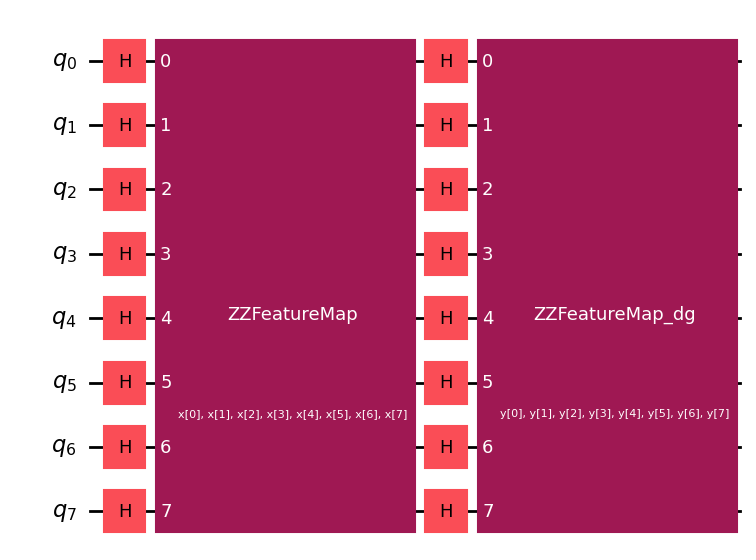

In [10]:
# Testing IBM fidelity class with this

#Dataset


#from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.primitives import Sampler

#service = QiskitRuntimeService()

#backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)

sampler = Sampler()

computer = ComputeUncompute(sampler=sampler)

#cc_circuit = computer.create_fidelity_circuit(U_map.decompose(), U_map_transpose.decompose())

#U_map_basis = transpile(U_map, backend=backend)
#U_map_T_basis = transpile(U_map_transpose, backend=backend)

#cc_circuit.draw("mpl")

h_U_map = QuantumCircuit(NUM_QUBITS)

for i in range(NUM_QUBITS):
    h_U_map.h(i)

h_U_map = h_U_map.compose(U_map)

U_h_map = QuantumCircuit(NUM_QUBITS)

U_map_y = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=2, entanglement="linear", parameter_prefix='y')

U_h_map = U_h_map.compose(U_map_y)


for i in range(NUM_QUBITS):
    U_h_map.h(i)



for i, datapoint in enumerate(dataset):
    x_vals = datapoint[:8]
    y_vals = datapoint[8:]
    job = computer.run(h_U_map, U_h_map, x_vals, y_vals)
    print(job.result().fidelities)

#h_U_map.draw("mpl")

cc_circuit = computer.create_fidelity_circuit(h_U_map, U_h_map)

cc_circuit.remove_final_measurements()

cc_circuit.draw("mpl")

#Readd decomposes to circuit creation.

# Of course the fidelity between the two circuits are going to be different if the circuits are different, the kernel function/fidelity function is different since the mapping function is different.
# This is normal. Question becomes: which circuit do you use? This is not so urgent, as we have comfirmed that the expectation value method produces a close-enough result to the fidelity function.
# Still might be worth asking Bhatia why they added the hadamards to their diagram.

### Function to evaluate fidelity manually
## In preparation for Kernel computation

In [33]:
def fidelity(circuit, pass_manager, backend, num_qubits, zero_proj_op, left_params, right_params):
    fid = 0

    # Check if left params  = right params:
    
    comp_params = np.concatenate((left_params, right_params))

    print(comp_params)

    bd_circuit = circuit.assign_parameters(comp_params)

    isa_circuit = pass_manager.run(bd_circuit)

    isa_observable = zero_proj_op.apply_layout(isa_circuit.layout)

    estimator = Estimator(backend, options={"default_shots": int(1e6)})

    job = estimator.run([(isa_circuit, isa_observable)])

    pub_result = job.result()[0]
    
    fid = pub_result.data.evs
    
    return fid

In [41]:
## Test of fidelity function

fidelity_result = fidelity(circuit=circuit, pass_manager=pass_manager, backend=backend, num_qubits=NUM_QUBITS, zero_proj_op=proj_0_op, left_params=datapoint[:8], right_params=datapoint[8:])
#circuit.draw("mpl")

print(datapoint)

print(fidelity_result)

#print(datapoint[:8])

#print(datapoint[8:])

#merged_data = np.concatenate((datapoint[:8], datapoint[8:]))

#print(merged_data)

[0.91651904 0.63148592 0.56067687 0.5682749  0.65091995 0.30000968
 0.62761952 0.21907652 0.49551579 0.48867206 0.36543813 0.49640117
 0.98868653 0.21139759 0.71329413 0.64060852]
[0.91651904 0.63148592 0.56067687 0.5682749  0.65091995 0.30000968
 0.62761952 0.21907652 0.49551579 0.48867206 0.36543813 0.49640117
 0.98868653 0.21139759 0.71329413 0.64060852]
0.0006359999999999988


## Importing carc data

In [ ]:
# prepare the data
import pandas as pd
from sklearn.model_selection import train_test_split

# File paths
features_file = "carc_16comp_x.csv"
labels_file = "carc_16comp_y.csv"

# Load the data
features_df = pd.read_csv(features_file)
labels_df = pd.read_csv(labels_file)

labels = labels_df.values.ravel()

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

# Check shape of data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((268, 16), (67, 16), (268,), (67,))

In [ ]:
## Fidelity Quantum Kernel evaluation function to produce kernel matrix.

def evaluate(self, x_vec: np.ndarray, y_vec: np.ndarray | None = None) -> np.ndarray:
        x_vec, y_vec = self._validate_input(x_vec, y_vec)

        # determine if calculating self inner product
        is_symmetric = True
        if y_vec is None:
            y_vec = x_vec
        elif not np.array_equal(x_vec, y_vec):
            is_symmetric = False

        kernel_shape = (x_vec.shape[0], y_vec.shape[0])

        if is_symmetric:
            left_parameters, right_parameters, indices = self._get_symmetric_parameterization(x_vec)
            kernel_matrix = self._get_symmetric_kernel_matrix(
                kernel_shape, left_parameters, right_parameters, indices
            )
        else:
            left_parameters, right_parameters, indices = self._get_parameterization(x_vec, y_vec)
            kernel_matrix = self._get_kernel_matrix(
                kernel_shape, left_parameters, right_parameters, indices
            )

        if is_symmetric and self._enforce_psd:
            kernel_matrix = self._make_psd(kernel_matrix)

        return kernel_matrix

def _validate_input(
        self, x_vec: np.ndarray, y_vec: np.ndarray | None
    ) -> tuple[np.ndarray, np.ndarray | None]:
        x_vec = np.asarray(x_vec)

        if x_vec.ndim > 2:
            raise ValueError("x_vec must be a 1D or 2D array")

        if x_vec.ndim == 1:
            x_vec = np.reshape(x_vec, (-1, len(x_vec)))

        if x_vec.shape[1] != self._num_features:
            # before raising an error we try to adjust the feature map
            # to the required number of qubit.
            try:
                self._feature_map.num_qubits = x_vec.shape[1]
            except AttributeError as a_e:
                raise ValueError(
                    f"x_vec and class feature map have incompatible dimensions.\n"
                    f"x_vec has {x_vec.shape[1]} dimensions, "
                    f"but feature map has {self._feature_map.num_parameters}."
                ) from a_e
            



In [171]:
# cutting kernel
from disqco.parti.genetic.genetic_algorithm_original import Genetic_Partitioning

genetic_partitioner = Genetic_Partitioning(circuit, qpu_sizes, gate_packing=True)


results = genetic_partitioner.run(pop_size=100,num_generations=100,mutation_rate=0.9, multi_process=True, log_frequency=10, search_method=True,search_number=100)



KeyError: 'type'